In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


In [26]:
def read_data():
    df = pd.read_csv('hepatitis.csv')
    Q1 = df.quantile(0.05)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    dataset_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return dataset_out.to_numpy()
#convert to numpy make it faster

In [27]:
# data set to 0 - 1 impact remains the same
def normalize(data):
    minimums = np.min(data,axis=0)
    maximums =np.max(data,axis=0)
    rng= maximums-minimums
    normalize_data = 1-((maximums-data)/rng)
    return normalize_data

In [28]:
# normalize_data = 1-((maximums-dataset)/rng)
# normalize_data

In [29]:
# def visualize(X,y,thetas):
#     x_0 = X[np.where(y==0.0)]
#     x_1 = X[np.where(y==1.0)]
    
#     plt.scatter([x_0[:,1]],[x_0[:,2]],c ='b',label='y=0')
#     plt.scatter([x_1[:,1]],[x_1[:,2]],c ='r',label='y=1')
    
#     x1 = np.arange(0, 1, 0.1)
#     x2 = -(thetas[0,0] + thetas[0,1]*x1)/thetas[0,2]
#     plt.plot(x1, x2, c = 'k', label = 'reg line')
    
#     plt.xlabel('x1')
#     plt.ylabel('x2')
#     plt.legend()
    
#     plt.show()

In [30]:
#  1/(1+e^-a)
def logistc_function(thetas,X):
    #sygmoid
    return 1.0/(1+np.exp(-np.dot(X,thetas.T)))
    

In [31]:
def cost_func(thetas, X, y):
    log_func_value = logistc_function(thetas, X)
    step1 = y.T* np.log(log_func_value)
    step2 = (1 - y).T * np.log(1 - log_func_value)
    return np.mean(-step1 - step2)

In [32]:
# return direction
def log_gradient(thetas, X, y): 
    calc_1 = logistc_function(thetas, X) - y.reshape(X.shape[0],1) 
    calc_f = np.dot(calc_1.T, X) 
    return calc_f

In [33]:
#thetas is random but will go to the global minima
def fit(X, y, thetas, learning_rate, convergance_criteria):
    cost = cost_func(thetas , X, y)
    change = 1
    iter_count = 1
    
    while(change > convergance_criteria):
        # learning_rate *= 0.9
        old_cost = cost
        thetas = thetas - (learning_rate * log_gradient(thetas, X, y))
        cost = cost_func(thetas, X, y)
        change = old_cost - cost
        iter_count += 1
        
    return thetas , iter_count
    

In [34]:
def cross_validation(train_X,train_Y,w,learning_rate,epsilon,length):
    Err_A=0
    lowest=1000;
    bestw=w;
    initw=w;
    for k in range(1,11):
        low= length * (k - 1)
        up = length * k - 1
        w=initw
        validate_x=train_X[low:up,:]
        t_x=np.append(train_X[0:low,:],train_X[up:(length * 10 - 1),:],axis=0)
        validate_y=train_Y[low:up,:]
        t_y=np.append(train_Y[0:low,:],train_Y[up:(length * 10 - 1),:],axis=0)
        w ,count= fit(t_x,t_y,w,learning_rate,epsilon)
        Xw = np.dot(validate_x,w.T)
        a = np.dot(validate_y.T,validate_y)
        b = 2 * np.dot(validate_y.T,Xw)
        c = np.dot(validate_x,w.T)
        d = np.dot(c.T,Xw)
        err = a - b + d
        # print("Err =" + str(err))
        y_pred = predict(w,validate_x)
        y_pred = y_pred[:,None]
        corrects = Accu_eval(y_pred,validate_y,length)
        print("Accuracy: " + str(corrects) + "%")

        Err_A += err
        if(err<lowest):
           lowest=err
           bestw=w
 
    Err_A = Err_A / 10
    return (Err_A,w)

In [35]:
def predict(thetas, X):
    prob = logistc_function(thetas,X)
    #dicision boundary
    predicted_value = np.where(prob > 0.5, 1, 0)
    return np.squeeze(predicted_value)

In [36]:
def Accu_eval(y_pred,y,length):
    corrects = np.sum(y == y_pred)/length * 100
    return corrects

In [64]:
#main
start_time = time.time()


learning_rate =0.01
covergance_criteria = 0.000001
dataset = read_data()
trainNum = dataset.shape[0]
print(trainNum)
while(trainNum % 10 != 0):
    trainNum = trainNum -1
print(trainNum)
testNum = int(trainNum/10)
normalized = normalize(dataset)

# copy all the rows apart from last column
X = normalized[:trainNum,:-1]
test_X = normalized[-testNum:,:-1]

#add ones as first column
# print(X.shape)
# np.hstack add 1s on first column
test_X = np.hstack((np.matrix(np.ones(test_X.shape[0])).T,test_X))
X = np.hstack((np.matrix(np.ones(X.shape[0])).T,X))
# copy last column
# y = normalized[:127,-1]
y = normalized[:trainNum,-1]
test_y = normalized[-testNum:,-1]
print(test_y)

#init thetas just zeros
thetas = np.matrix(np.zeros(X.shape[1]))
#training the thetas
(final_thetas, iter_count) = fit(X,y,thetas,learning_rate,covergance_criteria)
y_pred = predict(final_thetas,test_X)
corrects = np.sum(test_y == y_pred)
total = test_y.__len__()
print("fit function(Gradient descent): ") 

print("Accuracy without cross validation ", corrects/total * 100)
print("--- %s seconds ---" % (time.time() - start_time))
newTime = time.time()

print("\n 10 folder corss validation:")
y=y[:,None]

err, final_thetas = cross_validation(X,y,thetas,learning_rate,covergance_criteria,testNum)
print("--- %s seconds ---" % (time.time() - newTime))

140
140
[0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
fit function(Gradient descent): 
Accuracy without cross validation  92.85714285714286
--- 1.0180232524871826 seconds ---

 10 folder corss validation:
Accuracy: 85.71428571428571%
Accuracy: 92.85714285714286%
Accuracy: 71.42857142857143%
Accuracy: 92.85714285714286%
Accuracy: 78.57142857142857%
Accuracy: 78.57142857142857%
Accuracy: 50.0%
Accuracy: 71.42857142857143%
Accuracy: 71.42857142857143%
Accuracy: 64.28571428571429%
--- 9.434754133224487 seconds ---


     attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0         False       False       False       False       False       False   
1         False       False       False       False       False       False   
2         False       False       False       False       False       False   
3         False       False       False       False       False       False   
4         False       False       False       False       False       False   
..          ...         ...         ...         ...         ...         ...   
448       False       False       False       False       False       False   
449       False       False       False       False       False       False   
450       False       False       False       False       False       False   
451       False       False       False       False       False       False   
452       False       False       False       False       False       False   

     attribute7  attribute8  attribute9  attribute1

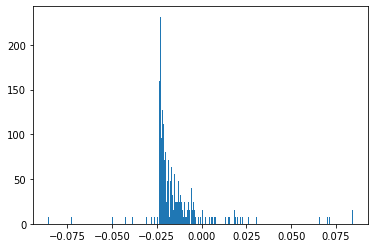

In [60]:
# dataset = pd.read_csv('hepatitis.csv')
dataset = pd.read_csv('bankrupcy.csv')

# plt.hist(dataset["attribute59"], density=True, bins=453)
dataset.describe()
Q1 = dataset.quantile(0.05)
Q3 = dataset.quantile(0.95)
IQR = Q3 - Q1
dataset_out = dataset[~((dataset < (Q1 - 1.5 * IQR)) |(dataset > (Q3 + 1.5 * IQR))).any(axis=1)]
plt.hist(dataset_out["attribute59"], density=True, bins=453)
print(dataset < (Q1 - 1.5 * IQR))
print(dataset.shape)
print(dataset_out.shape)

In [40]:
print(dataset["sgot"])
plt.hist(dataset["sgot"], density=True, bins=141)

KeyError: 'sgot'

In [ ]:
dataset[ (dataset['ClassLabel']==1)].__len__()

In [ ]:
dataset[ (dataset['ClassLabel']==0)].__len__()

In [ ]:
dataset[ (dataset['ClassLabel']==0) & (dataset['sex'] == 1)].__len__()

In [ ]:
dataset[ (dataset['ClassLabel']==0)].__len__()

In [ ]:
dataset[ (dataset['ClassLabel']==0) & (dataset['sex'] == 2)].__len__()

In [ ]:
y = dataset[dataset['ClassLabel']==1].groupby('sex')['protime'].count()
print(y)
x=['Females','Males']
plt.bar(x,y)
plt.title('Class1 wrt Gender')

In [ ]:
y = dataset[dataset['ClassLabel']==0].groupby('age')['protime'].count()

print(y)
x=dataset[ (dataset['ClassLabel']==0)]['age'].unique()
print(x)
plt.bar(x,y)
plt.title('Class0 wrt Age')
plt.ylim([0,10])
plt.xlim([20,80])

In [ ]:
datasetNoFirstColumn = read_data();
print(datasetNoFirstColumn)
print(datasetNoFirstColumn.shape)

In [ ]:
datasetNoFirstColumn.describe()

In [48]:
df = pd.read_csv('bankrupcy.csv')
df.corr()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,...,attribute56,attribute57,attribute58,attribute59,attribute60,attribute61,attribute62,attribute63,attribute64,ClassLabel
attribute1,1.000000,-0.368068,0.336251,0.265596,0.030680,0.019219,0.992661,0.222475,0.117261,0.384063,...,0.130066,0.169502,-0.189025,-0.016159,0.017156,0.023171,-0.012462,0.358401,0.002298,-0.275046
attribute2,-0.368068,1.000000,-0.632313,-0.453199,-0.044202,-0.049855,-0.374551,-0.593418,0.152537,-0.993199,...,-0.071817,-0.084682,0.070429,0.074950,0.023972,0.052133,0.014649,-0.447783,0.087644,0.323921
attribute3,0.336251,-0.632313,1.000000,0.671794,0.126682,0.032082,0.359573,0.388465,-0.057316,0.628710,...,0.085549,0.062150,-0.084256,-0.061013,-0.135181,-0.203062,-0.041794,0.494766,0.093876,-0.267652
attribute4,0.265596,-0.453199,0.671794,1.000000,0.063052,0.029544,0.282638,0.621498,-0.072784,0.452207,...,0.076811,0.053479,-0.079083,-0.027049,-0.072947,-0.108968,-0.036924,0.726561,0.000279,-0.271784
attribute5,0.030680,-0.044202,0.126682,0.063052,1.000000,0.002026,0.033146,0.029315,0.049680,0.044242,...,0.255754,0.007619,-0.259905,-0.002216,0.003155,-0.114400,-0.268884,0.057917,0.000093,-0.049772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
attribute61,0.023171,0.052133,-0.203062,-0.108968,-0.114400,0.003534,0.020489,-0.030656,0.291261,-0.047222,...,0.002442,-0.003657,-0.014986,0.113614,0.039114,1.000000,-0.036143,0.207788,-0.027026,0.000254
attribute62,-0.012462,0.014649,-0.041794,-0.036924,-0.268884,0.002365,-0.015430,-0.020944,-0.072328,-0.012968,...,-0.961593,0.002303,0.957046,-0.002049,-0.014430,-0.036143,1.000000,-0.066104,-0.010712,-0.035863
attribute63,0.358401,-0.447783,0.494766,0.726561,0.057917,0.019499,0.376443,0.562082,0.316144,0.454076,...,0.090437,0.068728,-0.109271,-0.026847,0.029389,0.207788,-0.066104,1.000000,0.001096,-0.268469
attribute64,0.002298,0.087644,0.093876,0.000279,0.000093,0.006648,0.009498,-0.057460,0.152127,-0.084852,...,0.012873,-0.003414,-0.016724,-0.009661,-0.016102,-0.027026,-0.010712,0.001096,1.000000,0.092562


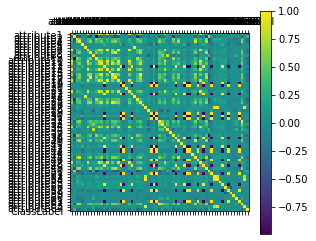

In [49]:
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

(453, 64)
(453, 29)


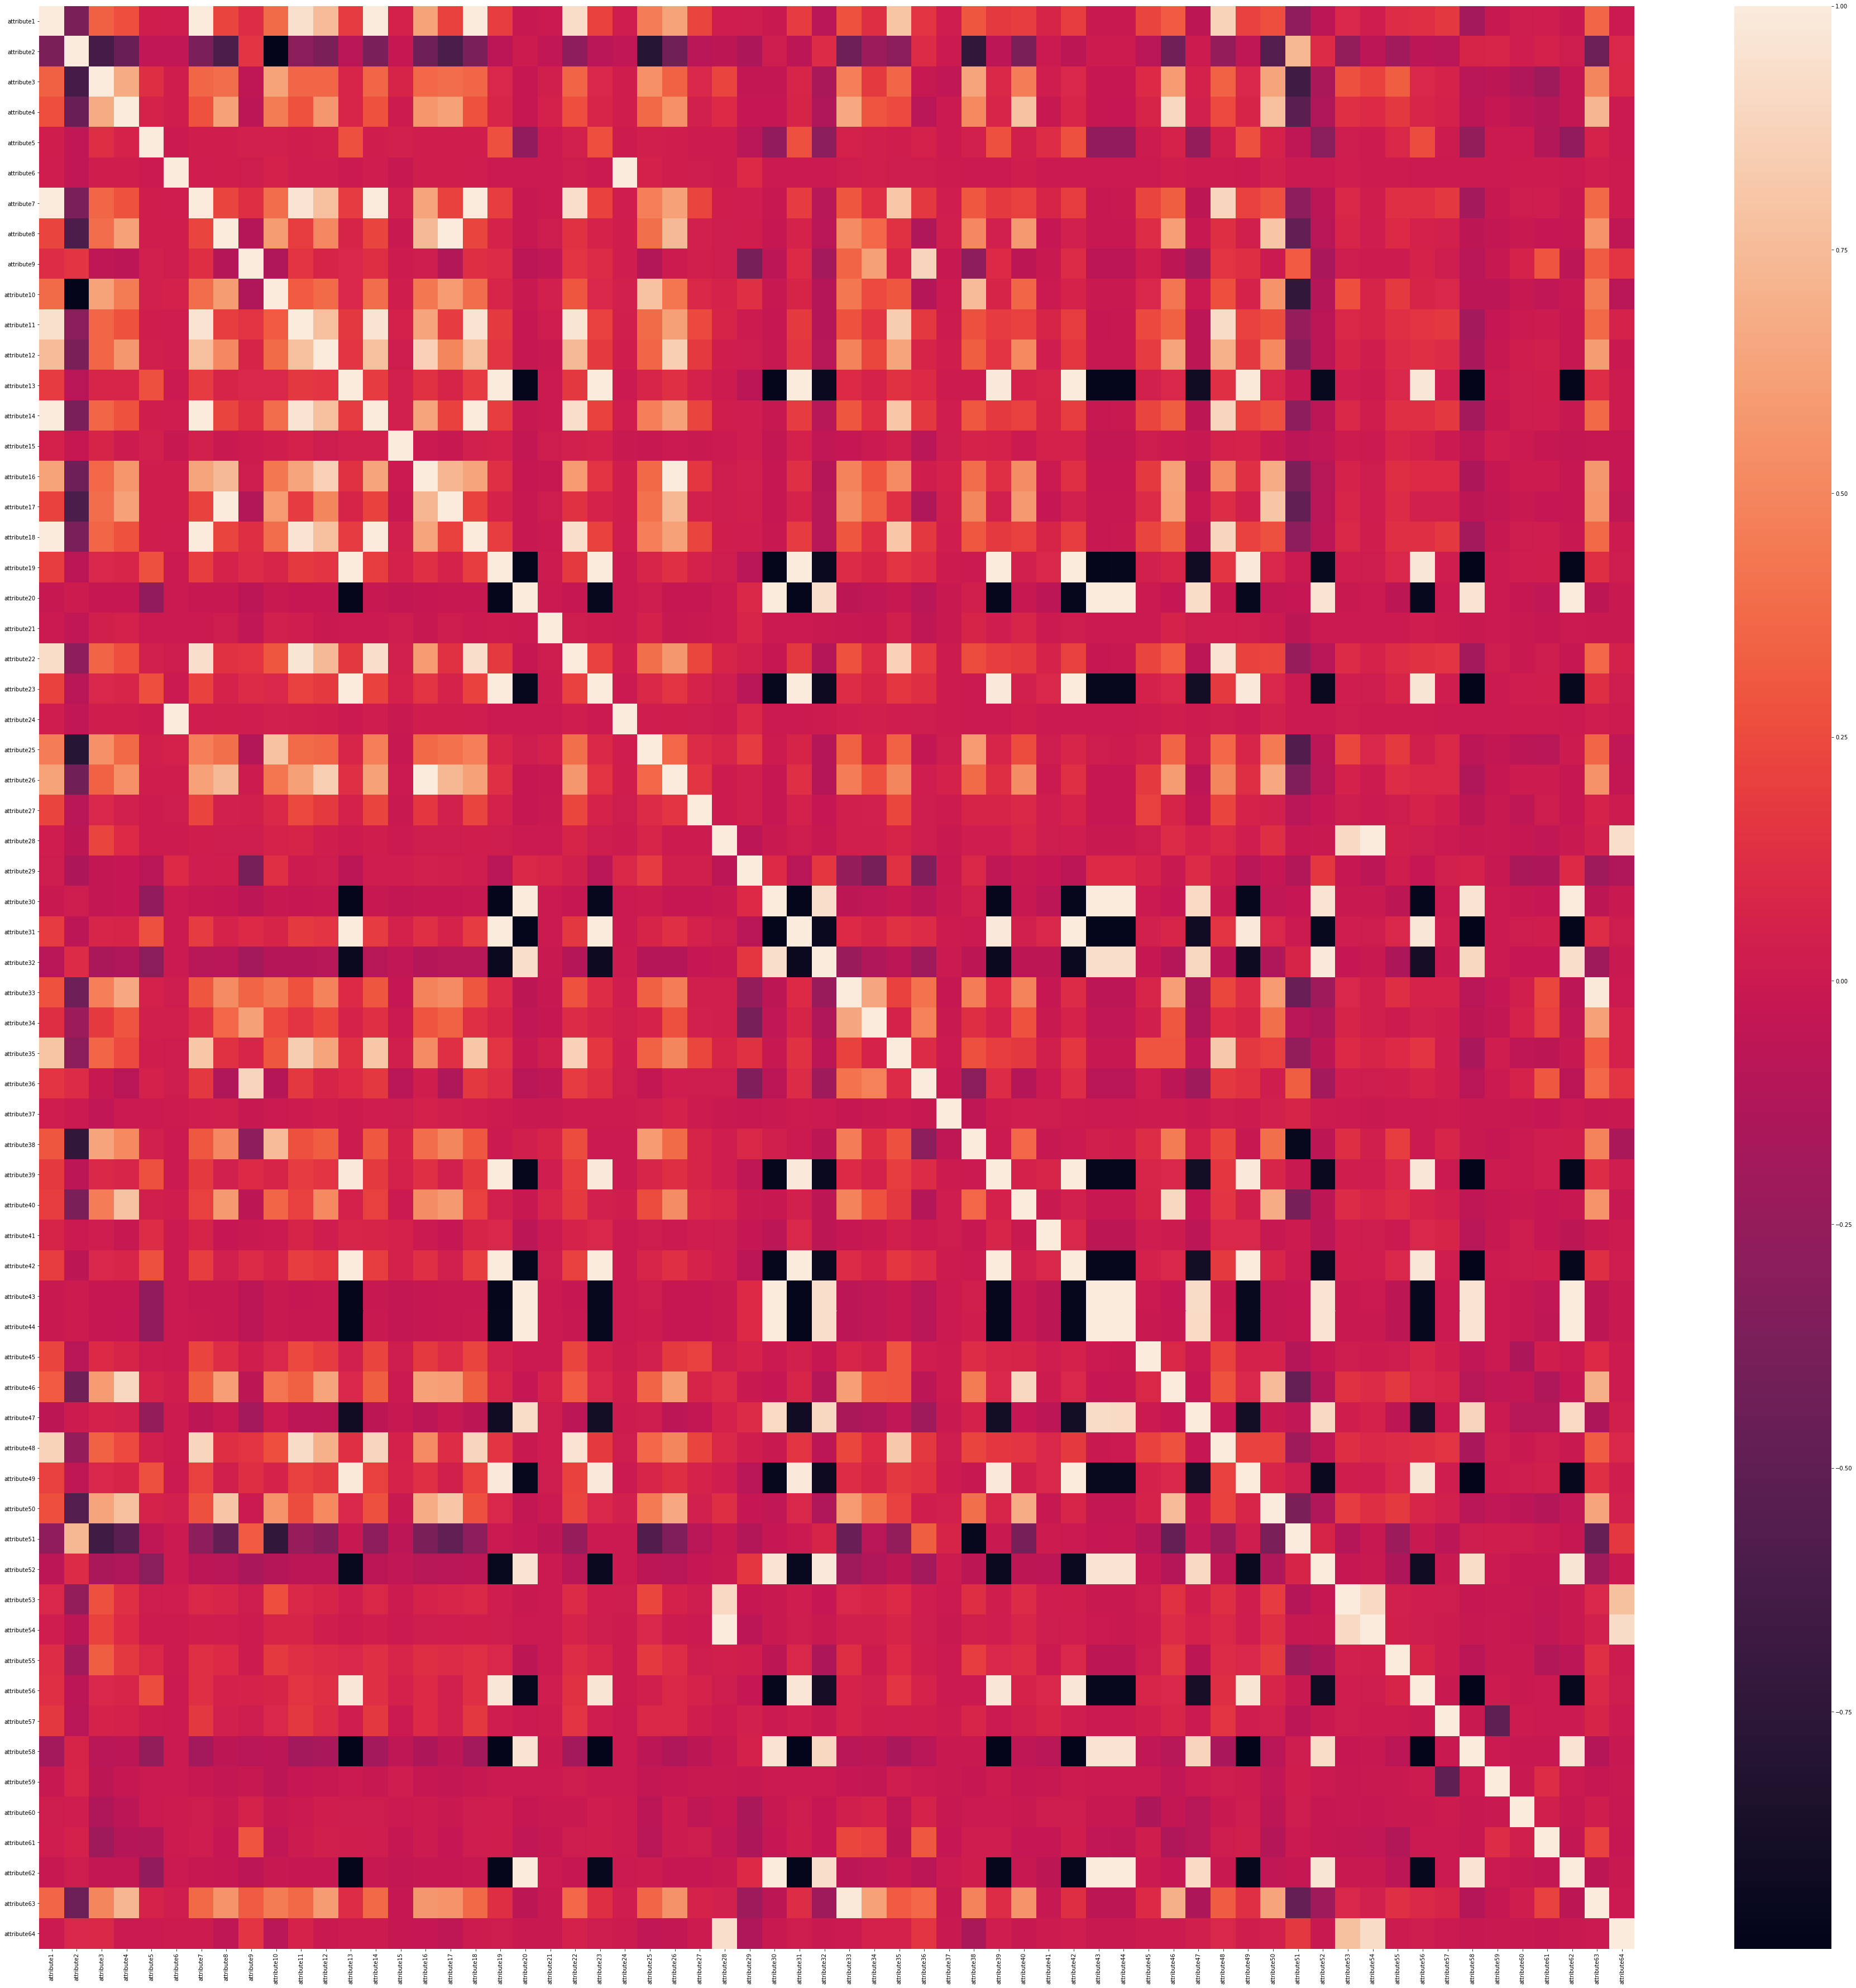

In [56]:
import seaborn as sns
# creating set to hold the correlated features
df = pd.read_csv('bankrupcy.csv')
# df = df.to_numpy()
x_train= df.iloc[:,0:-1]
# normalized = normalize(df)
# x_train= normalized[:trainNum,:-1]

corr_features = set()

# create the correlation matrix (default to pearson)
corr_matrix = x_train.corr()

# optional: display a heatmap of the correlation matrix
plt.figure(figsize=(64,64))
sns.heatmap(corr_matrix)

for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
            
print(x_train.shape)           
x_train.drop(labels=corr_features, axis=1, inplace=True)
print(x_train.shape)